<a href="https://colab.research.google.com/github/acollin19/comp551/blob/main/A3/assignment3_group_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from keras.datasets import fashion_mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


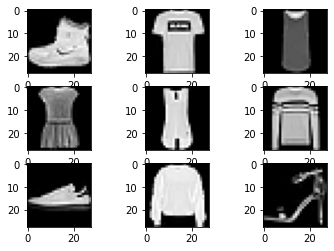

In [2]:
# load dataset
(X_train, y_train_val), (X_test, y_test_val) = fashion_mnist.load_data()

print('Train: X=%s, y=%s' % (X_train.shape, y_train_val.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test_val.shape))

# plotting raw pixel data
for i in range(9):
	pyplot.subplot(330 + 1 + i) # subplot
	pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray')) 
pyplot.show()

In [3]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_train = X_train - np.mean(X_train, axis=0)
X_train = X_train / np.std(X_train, axis=0)

X_test = X_test.reshape(X_test.shape[0], 784)
X_test = X_test - np.mean(X_test, axis=0)
X_test = X_test / np.std(X_test, axis=0)

y_train = np_utils.to_categorical(y_train_val, 10) #10 classes
y_train = y_train == 1

y_test = np_utils.to_categorical(y_test_val, 10)
y_test = y_test == 1

## Multi Layered Perceptron (MLP) Class

In [4]:
from typing import List

class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size) / 10
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient
        
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

In [5]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)

In [6]:
from tqdm import tqdm
def train(mlp: MLP, optimizer: Optimizer, data_x, data_y, steps, batch_size):
    losses = []
    for _ in tqdm(range(steps)):
        indices = np.random.choice(data_x.shape[0], batch_size)
        batch_x = data_x[indices]
        batch_y = data_y[indices]
        predictions = mlp.forward(batch_x)
        loss = -(batch_y * np.log(predictions)).sum(axis=-1).mean()
        losses.append(loss)
        mlp.backward(batch_y)
        optimizer.step()
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")

def plot_decision_boundary(mlp: MLP, data_x, data_y):
    x0v = np.linspace(np.min(data_x[:,0]), np.max(data_x[:,0]), 200)
    x1v = np.linspace(np.min(data_x[:,1]), np.max(data_x[:,1]), 200)
    x0,x1 = np.meshgrid(x0v, x1v)
    x_all = np.vstack((x0.ravel(),x1.ravel())).T
    yh_all = np.argmax(mlp.forward(x_all), axis=-1)
    plt.scatter(data_x[:,0], data_x[:,1], c=data_y, marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
    plt.ylabel('sepal length')
    plt.xlabel('sepal width')
    plt.title('decision boundary of the MLP')
    plt.show()
    

## MLP with no hidden layers

100%|██████████| 20/20 [00:01<00:00, 15.93it/s]


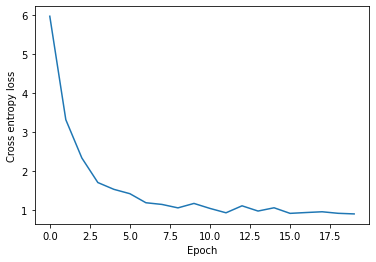

In [7]:
n_features = X_train.shape[-1]
GRADIENT_STEPS = 20

mlp0 = MLP(
    LinearLayer(n_features, 10),
    SoftmaxOutputLayer()
)
opt0 = GradientDescentOptimizer(mlp0, 1e-1)

train(mlp0, opt0, X_train, y_train, GRADIENT_STEPS, 1000) 

## MLP with one hidden layer

100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


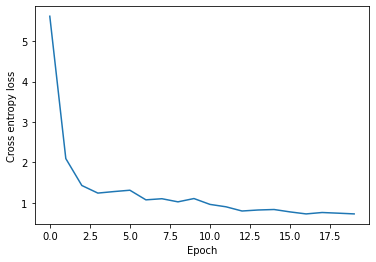

In [8]:
n_features = X_train.shape[-1]
HIDDEN_SIZE = 128
GRADIENT_STEPS = 20

mlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt1 = GradientDescentOptimizer(mlp1, 1e-1)

train(mlp1, opt1, X_train, y_train, GRADIENT_STEPS, 1000) 

## MLP with two hidden layers

100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


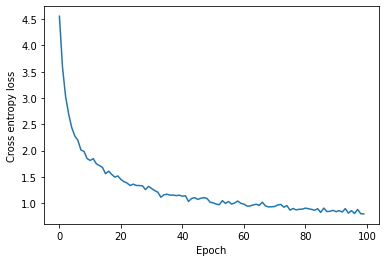

In [24]:
mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, 1e-2)

train(mlp2, opt2, X_train, y_train, 100, 1000)

In [25]:
# Test accuracy
np.sum(np.argmax(mlp2.forward(X_test), axis=1) == y_test_val) / X_test.shape[0]

0.7166